### 0.0. Libs & Enviroment

In [1]:
# pip install Cython --install-option="--no-cython-compile"
# pip install --upgrade setuptools

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import surprise

from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import BaseEstimator
import matplotlib as plt
import itertools
from collections import defaultdict

### 1.0. Download raw data


In [3]:
df = pd.read_csv('./steam-200k.csv') ###  https://www.kaggle.com/datasets/tamber/steam-video-games/data
df

user_id                   game_name behaviour  hours
0       151603712  The Elder Scrolls V Skyrim  purchase    1.0
1       151603712  The Elder Scrolls V Skyrim      play  273.0
2       151603712                   Fallout 4  purchase    1.0
3       151603712                   Fallout 4      play   87.0
4       151603712                       Spore  purchase    1.0
...           ...                         ...       ...    ...
199995  128470551                 Titan Souls      play    1.5
199996  128470551  Grand Theft Auto Vice City  purchase    1.0
199997  128470551  Grand Theft Auto Vice City      play    1.5
199998  128470551                        RUSH  purchase    1.0
199999  128470551                        RUSH      play    1.4

[200000 rows x 4 columns]

##### 1.1. represent data

In [4]:
df['user_id'] = df['user_id'].astype(str)
for col in df.columns:
    if col in 'hours':
        print('\n' + 'all sample')
        print(df.describe())     
        print('\n' + 'played')
        print(df[df['behaviour']=='play'].describe()) 
        
    else:
        print('\n' + str(col) + ' N unique ' +  str(df[col].nunique()))
        print('\n' + str(col) + ' top 10 ' +  str(df[col].value_counts()[:10]))
        print('\n' + str(col) + ' top 10 pct ' +  str(df[col].value_counts(normalize=True)[:10]))

pvt = pd.pivot_table(df, index=['game_name'], values='hours', aggfunc=np.sum).reset_index().sort_values('hours', ascending=False)
pvt['hours spent %'] = (pvt['hours'] / pvt['hours'].sum()) * 100
pvt.head(10)


user_id N unique 12393

user_id top 10 user_id
62990992     1573
33865373      949
11403772      906
30246419      901
47457723      855
58345543      833
22301321      775
49893565      774
138941587     747
64787956      723
Name: count, dtype: int64

user_id top 10 pct user_id
62990992     0.007865
33865373     0.004745
11403772     0.004530
30246419     0.004505
47457723     0.004275
58345543     0.004165
22301321     0.003875
49893565     0.003870
138941587    0.003735
64787956     0.003615
Name: proportion, dtype: float64

game_name N unique 5155

game_name top 10 game_name
Dota 2                             9682
Team Fortress 2                    4646
Counter-Strike Global Offensive    2789
Unturned                           2632
Left 4 Dead 2                      1752
Counter-Strike Source              1693
Counter-Strike                     1424
Garry's Mod                        1397
The Elder Scrolls V Skyrim         1394
Warframe                           1271
Name: count,

C:\Users\user\AppData\Local\Temp\ipykernel_21208\2032165859.py:14: FutureWarning: The provided callable <function sum at 0x000002475D0423A0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pvt = pd.pivot_table(df, index=['game_name'], values='hours', aggfunc=np.sum).reset_index().sort_values('hours', ascending=False)


game_name     hours  hours spent %
1336                                       Dota 2  986525.6      27.596073
981               Counter-Strike Global Offensive  324183.6       9.068385
4257                              Team Fortress 2  175996.3       4.923143
978                                Counter-Strike  135117.1       3.779630
3825                   Sid Meier's Civilization V  100417.3       2.808972
984                         Counter-Strike Source   97053.5       2.714877
4364                   The Elder Scrolls V Skyrim   71606.3       2.003042
1894                                  Garry's Mod   50456.3       1.411414
737   Call of Duty Modern Warfare 2 - Multiplayer   42352.9       1.184737
2475                                Left 4 Dead 2   34547.7       0.966403

##### 1.2. cleansing

In [5]:
# drop boring player
tmp = pd.pivot_table(df, index=['user_id'], values=['game_name'], aggfunc=pd.Series.nunique).reset_index()
drop_solo_players = tmp[tmp['game_name'] < 2]['user_id'].to_list()
drop_solo_players = ~df['user_id'].isin(drop_solo_players)

# drop outliers
tmp = pd.pivot_table(df, index=['user_id'], values=['hours'], aggfunc='sum').reset_index()
drop_outliers_playes = tmp[tmp['hours'] >= tmp['hours'].quantile(q=0.99)]['user_id'].to_list()
drop_outliers_playes = ~df['user_id'].isin(drop_outliers_playes)

# drop unplayed games
tmp = pd.pivot_table(df, index=['game_name'], values=['hours'], aggfunc = 'sum').reset_index().sort_values('hours', ascending=False)
drop_unplayed_games = tmp[tmp['hours'] < 2]['game_name'].to_list()
drop_unplayed_games = ~df['game_name'].isin(drop_unplayed_games)

# drop low represented games
tmp = pd.pivot_table(df, index=['game_name'], values=['user_id'], aggfunc=pd.Series.nunique).reset_index().sort_values(by='user_id')
drop_irrelevant_games = tmp[tmp['user_id'] < 2]['game_name'].to_list()
drop_irrelevant_games = ~df['game_name'].isin(drop_irrelevant_games)
df = df[(drop_solo_players) & (drop_outliers_playes) & (drop_unplayed_games) & (drop_irrelevant_games) & (df['behaviour']=='play')]

# extra game filters
games_dict = []
for game in tqdm(df['game_name'].unique()):
    prefix = 'game'
    tmp = df[(df['game_name']==game) & (df['behaviour']=='play')]
    res = pd.DataFrame(index=[game]) 
    if len(tmp) >= 5:
        res['q5 ' + prefix] = tmp['hours'].quantile(0.05)
        res['q10 ' + prefix] = tmp['hours'].quantile(0.10)
        res['mean '+ prefix] = tmp['hours'].mean()
    else:         
        res['q5 '+ prefix] = 1
        res['q10 ' + prefix] = 1
        res['mean ' + prefix] = 1
    res['users_played'] = tmp['user_id'].nunique()
    games_dict.append(res)
games_dict = pd.concat(games_dict).reset_index(names='game_name')

# extra user filters
users_dict = []
for user in tqdm(df['user_id'].unique()):
    prefix = 'user'
    tmp = df[(df['user_id']==user) & (df['behaviour']=='play')]
    res = pd.DataFrame(index=[user])  
    res['q5 ' + prefix] = tmp['hours'].quantile(0.05)
    res['q10 ' + prefix] = tmp['hours'].quantile(0.10)
    res['mean ' + prefix] = tmp['hours'].mean()
    res['games_played'] = tmp['game_name'].nunique()
    users_dict.append(res)
users_dict = pd.concat(users_dict).reset_index(names='user_id')

df = df.merge(users_dict, on='user_id', how='left').merge(games_dict, on='game_name', how='left')

# drop not relevant user for the current game
df = df[df['hours'] > df['q10 game']]

100%|██████████| 6106/6106 [00:39<00:00, 153.97it/s]


##### 1.3. ranking

In [6]:
ranks = []
for rating_, key_ in tqdm(zip(['game_name', 'user_id'], [df['game_name'].unique(), df['user_id'].unique()])):
    for k in key_:
        tmp = df[df[rating_] == k] 
        if len(tmp) >= 5:
            tmp[rating_ + ' rating'] = tmp['hours'].rank(pct=True)
            tmp[rating_ + ' rating'] = round(tmp[rating_ + ' rating'] * 100)
        else:
            tmp[rating_ + ' rating'] = None
        ranks.append(tmp[['user_id', 'game_name', rating_ + ' rating']])

ranks = pd.concat(ranks)

df = df.merge(ranks[~ranks['game_name rating'].isna()][['user_id', 'game_name', 'game_name rating']], on=['user_id', 'game_name'], how='left')
df = df.merge(ranks[~ranks['user_id rating'].isna()][['user_id', 'game_name', 'user_id rating']], on=['user_id', 'game_name'], how='left').sort_values(by=['user_id', 'game_name rating'])
# df.head(50)

0it [00:00, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_21208\204568101.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[rating_ + ' rating'] = tmp['hours'].rank(pct=True)
C:\Users\user\AppData\Local\Temp\ipykernel_21208\204568101.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[rating_ + ' rating'] = round(tmp[rating_ + ' rating'] * 100)
C:\Users\user\AppData\Local\Temp\ipykernel_21208\204568101.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

## 2.0. Surprise usage

user_id                   game_name behaviour  hours  q5 user  \
12292  100053304                      Dota 2      play    1.0    0.600   
12290  100053304                    Portal 2      play    4.4    0.600   
12291  100053304            PAYDAY The Heist      play    1.1    0.600   
12289  100053304   Dungeons & Dragons Online      play   12.6    0.600   
13933  100057229  The Elder Scrolls V Skyrim      play   19.3    6.985   
...          ...                         ...       ...    ...      ...   
10421   99766416     Half-Life 2 Episode One      play    6.4    0.975   
10420   99766416                 Half-Life 2      play   21.0    0.975   
41448   99802512             Train Simulator      play    6.9    7.705   
41447   99802512               Left 4 Dead 2      play   23.0    7.705   
39285   99906508            Empire Total War      play   22.0    2.715   

       q10 user  mean user  games_played  q5 game  q10 game   mean game  \
12292      0.70      3.920             5      0.3      0.50  289.066824   
12290      0.70      3.920             5      0.6      1.32   19.525666   
12291      0.70      3.920             5      0.3      0.46    7.977966   
12289      0.70      3.920             5      0.1      0.25   24.812500   
13933      7.27     10.825             4      1.0      2.00  103.311755   
...         ...        ...           ...      ...       ...         ...   
10421      1.65      8.125             4      0.2      0.40    5.686260   
10420      1.65      8.125             4      0.2      0.40   12.124921   
41448      8.51     14.950             2      0.2      0.40   20.497059   
41447      8.51     14.950             2      0.5      0.90   40.701132   
39285      3.73     11.850             2      0.5      1.09   97.045000   

       users_played  game_name rating  user_id rating  
12292          1905               6.0             NaN  
12290           413              17.0             NaN  
12291           177              17.0             NaN  
12289            16              64.0             NaN  
13933           604              28.0             NaN  
...             ...               ...             ...  
10421           131              64.0             NaN  
10420           317              78.0             NaN  
41448            34              45.0             NaN  
41447           707              67.0             NaN  
39285           160              44.0             NaN  

[49410 rows x 14 columns]

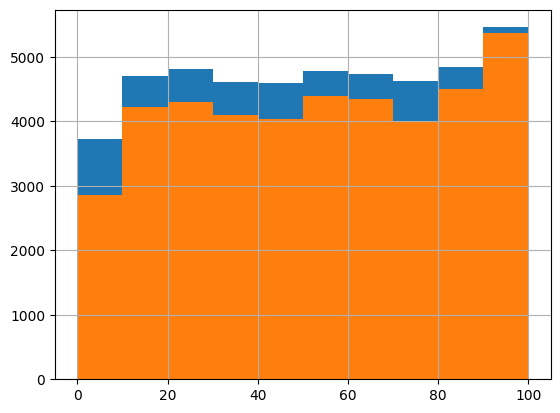

In [7]:
df['game_name rating'].hist(), df['user_id rating'].hist()
df

#### 2.1. surprise.BaselineOnly()

In [8]:
def surprise_usage(data,
                reader_line_format='user item rating', 
                   reader_rating_scale=(1, 100), 
                   model_type=surprise.BaselineOnly(),
                   output_metrics=['mae', 'rmse'],
                   cv=5,
                   verbose=True               
                   ):
    
    for col in data.columns:
        if data[col].isna().sum() > 0:
            print(col + ' includes NaNs. ' + str(data[col].isna().sum()) + ' observations were dropped')
        else:
            pass;
    data.dropna(inplace=True)
            
    reader = surprise.Reader(line_format=reader_line_format, rating_scale=reader_rating_scale)
    sample = surprise.Dataset.load_from_df(data, reader) 
    model = surprise.model_selection.cross_validate(model_type, sample, measures=output_metrics, cv=cv, verbose=verbose)
    return model

In [9]:
%%time
for rate in ['game_name rating', 'user_id rating']:
    cols = ['user_id', 'game_name', rate]
    surprise_usage(data=df[cols], reader_line_format='user item rating', reader_rating_scale=(1, 100), model_type=surprise.BaselineOnly(), output_metrics=['mae', 'rmse', 'fcp'], cv=5, verbose=True)

game_name rating includes NaNs. 2505 observations were dropped
Estimating biases using als...


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating MAE, RMSE, FCP of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     24.4902 24.7828 24.5260 24.5840 24.7040 24.6174 0.1100  
RMSE (testset)    28.4615 28.6858 28.4912 28.5532 28.6340 28.5651 0.0844  
FCP (testset)     0.4496  0.4525  0.4551  0.4609  0.4488  0.4534  0.0044  
Fit time          0.04    0.05    0.06    0.05    0.04    0.05    0.01    
Test time         0.02    0.02    0.02    0.09    0.02    0.03    0.03    
user_id rating includes NaNs. 7250 observations were dropped
Estimating biases using als...
Estimating biases using als...


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating MAE, RMSE, FCP of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     21.5949 21.4521 21.6097 21.2779 21.7415 21.5352 0.1580  
RMSE (testset)    25.4386 25.3088 25.3147 25.1137 25.5024 25.3356 0.1333  
FCP (testset)     0.6192  0.6278  0.6372  0.6299  0.6316  0.6291  0.0059  
Fit time          0.03    0.03    0.03    0.04    0.04    0.03    0.00    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    
CPU times: total: 1.48 s
Wall time: 1.47 s


#### 2.2 surprise.SVDpp()

In [10]:
svd = surprise.SVDpp(n_factors=3, n_epochs=30, lr_all=0.003, reg_all=0.05, random_state=42)
for rate in ['game_name rating', 'user_id rating']:
    cols = ['user_id', 'game_name', rate]
    surprise_usage(data=df[cols], reader_line_format='user item rating', reader_rating_scale=(1, 100), model_type=svd, output_metrics=['mae', 'rmse', 'fcp'], cv=5, verbose=True)   

game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Evaluating MAE, RMSE, FCP of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     28.1584 27.8951 27.5886 28.1553 27.9107 27.9416 0.2099  
RMSE (testset)    34.4365 34.0750 33.7202 34.4237 33.9792 34.1269 0.2734  
FCP (testset)     0.5130  0.5082  0.5044  0.5092  0.5053  0.5080  0.0031  
Fit time          0.62    0.64    0.63    0.62    0.63    0.63    0.01    
Test time         0.26    0.25    0.25    0.25    0.25    0.25    0.00    
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Evaluating MAE, RMSE, FCP of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     24.2506 23.8718 23.9398 24.0892 24.3498 24.1002 0.1805  
RMSE (testset)    30.1699 29.6846 29.8216 29.9897 30.4317 30.0195 0.2626  
FCP (testset)     0.6211  0.6128  0.6064  0.5993  0.6106  0.6100  0.0072  
Fit time          0.67    0.67    0.66    0.66    0.67    0.67    0.01    
Test time         0.26    0.29    0.28    0.28    0.34    0.29    0.03    


In [11]:
%%time
cv = [5]
learn_rate_all = [0.001, 0.003, 0.005, 0.01]
n_factors = [5, 10, 30, 50]
n_epochs = [30, 50]
params = list(itertools.product(cv, learn_rate_all, n_factors, n_epochs))
model_dict = {}

for rate in ['game_name rating', 'user_id rating']:
    cols = ['user_id', 'game_name', rate]
    for par in tqdm(params):
        ind = params.index(par)
        print(rate)
        print('model № ' + str(ind))
        print(par)
        svd = surprise.SVDpp(n_factors=par[2], n_epochs=par[3], lr_all=par[1], reg_all=0.05, random_state=42)
        model = surprise_usage(data=df[cols], reader_line_format='user item rating', reader_rating_scale=(1, 100), model_type=svd, output_metrics=['mae', 'rmse'], cv=par[0], verbose=True)
        model_dict[rate + '_' + str(int)] = model

  0%|          | 0/32 [00:00<?, ?it/s]

game_name rating
model № 0
(5, 0.001, 5, 30)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
  3%|▎         | 1/32 [00:05<02:46,  5.37s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     27.3443 27.7806 27.3279 27.3152 27.3377 27.4212 0.1800  
RMSE (testset)    33.1960 33.7305 33.1731 33.2042 33.2791 33.3166 0.2100  
Fit time          0.75    0.78    0.75    0.74    0.75    0.75    0.01    
Test time         0.25    0.25    0.26    0.25    0.25    0.25    0.00    
game_name rating
model № 1
(5, 0.001, 5, 50)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
  6%|▋         | 2/32 [00:13<03:24,  6.83s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     27.8871 27.9921 28.2444 28.3748 28.1489 28.1295 0.1740  
RMSE (testset)    34.1988 34.1262 34.5236 34.8231 34.2948 34.3933 0.2532  
Fit time          1.24    1.23    1.24    1.25    1.24    1.24    0.01    
Test time         0.28    0.31    0.26    0.25    0.25    0.27    0.02    
game_name rating
model № 2
(5, 0.001, 10, 30)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
  9%|▉         | 3/32 [00:20<03:19,  6.88s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     28.1123 28.3820 28.5717 28.4562 28.1838 28.3412 0.1704  
RMSE (testset)    34.3435 34.5753 34.6875 34.6959 34.3853 34.5375 0.1482  
Fit time          1.04    1.05    1.05    1.05    1.05    1.05    0.01    
Test time         0.29    0.26    0.25    0.32    0.26    0.28    0.03    
game_name rating
model № 3
(5, 0.001, 10, 50)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 12%|█▎        | 4/32 [00:30<03:50,  8.25s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     29.4149 29.4777 29.3867 29.2917 29.2091 29.3560 0.0948  
RMSE (testset)    35.8804 36.1339 36.0040 35.8211 35.8388 35.9356 0.1179  
Fit time          1.75    1.71    1.73    1.74    1.75    1.74    0.01    
Test time         0.26    0.33    0.26    0.26    0.26    0.27    0.03    
game_name rating
model № 4
(5, 0.001, 30, 30)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 16%|█▌        | 5/32 [00:43<04:28,  9.94s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     27.2439 27.1758 27.2540 27.2266 27.1527 27.2106 0.0395  
RMSE (testset)    32.9950 32.9398 32.9892 32.9604 32.8523 32.9473 0.0516  
Fit time          2.29    2.22    2.22    2.26    2.23    2.25    0.03    
Test time         0.26    0.26    0.26    0.32    0.27    0.27    0.02    
game_name rating
model № 5
(5, 0.001, 30, 50)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 19%|█▉        | 6/32 [01:03<05:49, 13.46s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     27.5872 27.6196 27.6851 27.4973 27.4924 27.5763 0.0736  
RMSE (testset)    33.3605 33.4441 33.4695 33.4388 33.2046 33.3835 0.0966  
Fit time          3.75    3.71    3.74    3.71    3.71    3.72    0.02    
Test time         0.26    0.26    0.27    0.26    0.26    0.26    0.00    
game_name rating
model № 6
(5, 0.001, 50, 30)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 22%|██▏       | 7/32 [01:23<06:30, 15.61s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     26.4169 26.2022 26.1808 26.1134 26.3317 26.2490 0.1098  
RMSE (testset)    31.6613 31.4632 31.3813 31.3663 31.5492 31.4842 0.1100  
Fit time          3.56    3.58    3.65    3.56    3.81    3.63    0.09    
Test time         0.35    0.27    0.26    0.31    0.30    0.30    0.03    
game_name rating
model № 7
(5, 0.001, 50, 50)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 25%|██▌       | 8/32 [01:54<08:08, 20.37s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     26.1208 25.9108 25.9621 26.2987 26.0465 26.0678 0.1359  
RMSE (testset)    31.2912 31.1415 31.1671 31.4071 31.1727 31.2359 0.1000  
Fit time          5.81    5.79    5.82    5.79    5.68    5.78    0.05    
Test time         0.26    0.27    0.26    0.26    0.27    0.26    0.01    
game_name rating
model № 8
(5, 0.003, 5, 30)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 28%|██▊       | 9/32 [01:59<06:00, 15.65s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     29.5648 29.0936 29.2173 28.9559 29.4485 29.2560 0.2238  
RMSE (testset)    36.0583 35.6992 35.8023 35.6225 36.1653 35.8695 0.2087  
Fit time          0.74    0.76    0.74    0.73    0.74    0.74    0.01    
Test time         0.25    0.31    0.25    0.25    0.25    0.26    0.02    
game_name rating
model № 9
(5, 0.003, 5, 50)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 31%|███▏      | 10/32 [02:07<04:51, 13.26s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     29.7464 29.2216 29.7749 29.6855 29.8516 29.6560 0.2237  
RMSE (testset)    36.5683 35.8778 36.5652 36.6601 36.5809 36.4504 0.2884  
Fit time          1.28    1.22    1.25    1.22    1.25    1.24    0.02    
Test time         0.25    0.25    0.26    0.31    0.25    0.27    0.02    
game_name rating
model № 10
(5, 0.003, 10, 30)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 34%|███▍      | 11/32 [02:14<03:57, 11.29s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     30.1783 30.3234 30.1589 30.4883 30.5901 30.3478 0.1694  
RMSE (testset)    37.1124 37.2918 37.1262 37.3226 37.4980 37.2702 0.1420  
Fit time          1.03    1.02    1.04    1.04    1.05    1.04    0.01    
Test time         0.26    0.26    0.26    0.25    0.26    0.26    0.00    
game_name rating
model № 11
(5, 0.003, 10, 50)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 38%|███▊      | 12/32 [02:24<03:39, 10.99s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     31.2117 30.9269 30.9680 30.6441 31.0908 30.9683 0.1903  
RMSE (testset)    38.4053 38.0451 38.1288 37.8128 38.1804 38.1145 0.1923  
Fit time          1.73    1.70    1.73    1.75    1.71    1.73    0.02    
Test time         0.26    0.26    0.26    0.33    0.26    0.27    0.03    
game_name rating
model № 12
(5, 0.003, 30, 30)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 41%|████      | 13/32 [02:37<03:40, 11.62s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     27.4852 27.6006 27.8619 27.3445 27.8154 27.6215 0.1955  
RMSE (testset)    33.3216 33.4327 33.6370 33.0813 33.5646 33.4074 0.1958  
Fit time          2.24    2.25    2.25    2.30    2.35    2.28    0.04    
Test time         0.26    0.26    0.26    0.26    0.27    0.26    0.00    
game_name rating
model № 13
(5, 0.003, 30, 50)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 44%|████▍     | 14/32 [02:58<04:17, 14.31s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     27.1304 27.7074 27.5805 27.5782 27.2859 27.4565 0.2138  
RMSE (testset)    32.8283 33.5767 33.2370 33.2224 32.9828 33.1694 0.2547  
Fit time          3.81    3.72    3.76    3.77    3.74    3.76    0.03    
Test time         0.35    0.26    0.26    0.25    0.32    0.29    0.04    
game_name rating
model № 14
(5, 0.003, 50, 30)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 47%|████▋     | 15/32 [03:17<04:27, 15.74s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     26.0663 26.1180 26.2951 25.9505 25.7216 26.0303 0.1901  
RMSE (testset)    31.2294 31.2614 31.3358 31.0644 30.8102 31.1402 0.1874  
Fit time          3.49    3.52    3.50    3.44    3.45    3.48    0.03    
Test time         0.26    0.26    0.26    0.32    0.26    0.27    0.02    
game_name rating
model № 15
(5, 0.003, 50, 50)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 50%|█████     | 16/32 [03:47<05:21, 20.11s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     25.8480 25.9889 25.7903 26.1030 26.3239 26.0108 0.1908  
RMSE (testset)    30.8522 31.1270 30.7638 31.1110 31.4151 31.0538 0.2297  
Fit time          5.72    5.73    5.72    5.81    5.63    5.72    0.06    
Test time         0.26    0.26    0.26    0.25    0.25    0.26    0.00    
game_name rating
model № 16
(5, 0.005, 5, 30)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 53%|█████▎    | 17/32 [03:52<03:55, 15.67s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     30.4491 29.9386 30.1125 29.7927 29.8615 30.0309 0.2347  
RMSE (testset)    37.3115 36.8002 37.1038 36.6222 36.7885 36.9252 0.2479  
Fit time          0.74    0.74    0.72    0.74    0.76    0.74    0.01    
Test time         0.31    0.25    0.25    0.32    0.26    0.28    0.03    
game_name rating
model № 17
(5, 0.005, 5, 50)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 56%|█████▋    | 18/32 [04:00<03:06, 13.31s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     30.1143 30.2248 30.7331 30.6259 30.3922 30.4181 0.2336  
RMSE (testset)    37.0300 37.2156 37.9119 37.6116 37.3493 37.4237 0.3090  
Fit time          1.21    1.25    1.24    1.22    1.24    1.23    0.02    
Test time         0.27    0.26    0.32    0.25    0.26    0.27    0.03    
game_name rating
model № 18
(5, 0.005, 10, 30)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 59%|█████▉    | 19/32 [04:07<02:27, 11.37s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     31.6854 31.4003 31.5301 30.9942 31.1118 31.3443 0.2571  
RMSE (testset)    38.9218 38.5676 38.6140 38.0450 38.3284 38.4953 0.2939  
Fit time          1.04    1.03    1.03    1.03    1.03    1.03    0.00    
Test time         0.26    0.25    0.25    0.25    0.31    0.26    0.02    
game_name rating
model № 19
(5, 0.005, 10, 50)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 62%|██████▎   | 20/32 [04:17<02:12, 11.02s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     31.3371 31.9761 31.2625 31.5140 31.6205 31.5420 0.2512  
RMSE (testset)    38.4844 39.2511 38.3319 38.9317 38.8768 38.7752 0.3293  
Fit time          1.71    1.69    1.76    1.70    1.73    1.72    0.02    
Test time         0.25    0.25    0.26    0.25    0.25    0.25    0.00    
game_name rating
model № 20
(5, 0.005, 30, 30)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 66%|██████▌   | 21/32 [04:30<02:07, 11.56s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     27.8807 27.8684 27.9266 48.2843 27.9007 31.9721 8.1561  
RMSE (testset)    33.6247 33.6194 33.8747 56.2720 33.7297 38.2241 9.0244  
Fit time          2.28    2.21    2.25    2.24    2.22    2.24    0.03    
Test time         0.26    0.31    0.26    0.26    0.26    0.27    0.02    
game_name rating
model № 21
(5, 0.005, 30, 50)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 69%|██████▉   | 22/32 [04:50<02:21, 14.14s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     27.6602 27.3623 48.9043 48.8377 27.5146 36.0558 10.4640 
RMSE (testset)    33.4460 32.9885 56.7520 56.7421 33.1442 42.6146 11.5400 
Fit time          3.74    3.65    3.66    3.69    3.72    3.69    0.03    
Test time         0.25    0.25    0.25    0.33    0.27    0.27    0.03    
game_name rating
model № 22
(5, 0.005, 50, 30)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 72%|███████▏  | 23/32 [05:09<02:20, 15.57s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     48.5218 48.6356 48.6213 48.4299 48.9932 48.6404 0.1914  
RMSE (testset)    56.4518 56.5739 56.5640 56.3658 56.8690 56.5649 0.1703  
Fit time          3.47    3.45    3.46    3.43    3.46    3.45    0.01    
Test time         0.25    0.26    0.32    0.26    0.26    0.27    0.02    
game_name rating
model № 23
(5, 0.005, 50, 50)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 75%|███████▌  | 24/32 [05:39<02:39, 20.00s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     48.8049 25.9120 48.5522 48.7245 48.6741 44.1336 9.1111  
RMSE (testset)    56.7347 30.8657 56.5585 56.6415 56.5742 51.4749 10.3048 
Fit time          5.77    5.70    5.72    5.71    5.70    5.72    0.03    
Test time         0.26    0.25    0.26    0.26    0.27    0.26    0.00    
game_name rating
model № 24
(5, 0.01, 5, 30)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 78%|███████▊  | 25/32 [05:45<01:49, 15.59s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     49.0637 48.1915 48.5142 48.6559 48.7765 48.6404 0.2883  
RMSE (testset)    56.9327 56.2108 56.4067 56.5870 56.6860 56.5646 0.2453  
Fit time          0.75    0.76    0.73    0.74    0.74    0.74    0.01    
Test time         0.25    0.24    0.25    0.24    0.25    0.25    0.00    
game_name rating
model № 25
(5, 0.01, 5, 50)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 81%|████████▏ | 26/32 [05:53<01:19, 13.26s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     48.6471 49.0980 48.2084 48.2953 48.9531 48.6404 0.3501  
RMSE (testset)    56.5041 56.8566 56.0677 56.4193 56.9734 56.5642 0.3238  
Fit time          1.22    1.21    1.22    1.24    1.25    1.23    0.01    
Test time         0.26    0.25    0.25    0.26    0.32    0.27    0.03    
game_name rating
model № 26
(5, 0.01, 10, 30)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 84%|████████▍ | 27/32 [05:59<00:56, 11.33s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     48.5976 48.6395 49.1502 48.1053 48.7092 48.6404 0.3325  
RMSE (testset)    56.5183 56.5434 56.9735 56.0677 56.7189 56.5644 0.2968  
Fit time          1.03    1.04    1.04    1.04    1.04    1.04    0.00    
Test time         0.27    0.25    0.25    0.32    0.25    0.27    0.03    
game_name rating
model № 27
(5, 0.01, 10, 50)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 88%|████████▊ | 28/32 [06:10<00:44, 11.02s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     48.5880 48.5947 48.5154 48.9769 48.5268 48.6404 0.1712  
RMSE (testset)    56.4814 56.5573 56.5306 56.8195 56.4362 56.5650 0.1339  
Fit time          1.72    1.83    1.71    1.72    1.71    1.74    0.05    
Test time         0.25    0.33    0.25    0.25    0.26    0.27    0.03    
game_name rating
model № 28
(5, 0.01, 30, 30)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 91%|█████████ | 29/32 [06:23<00:34, 11.61s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     48.4986 48.7172 48.6158 48.7335 48.6367 48.6404 0.0840  
RMSE (testset)    56.5540 56.6550 56.4805 56.6422 56.4939 56.5651 0.0726  
Fit time          2.28    2.24    2.25    2.25    2.23    2.25    0.02    
Test time         0.27    0.26    0.26    0.34    0.26    0.28    0.03    
game_name rating
model № 29
(5, 0.01, 30, 50)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 94%|█████████▍| 30/32 [06:43<00:28, 14.19s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     48.5283 48.4730 48.8504 48.7922 48.5578 48.6404 0.1514  
RMSE (testset)    56.5521 56.2965 56.8477 56.6762 56.4518 56.5649 0.1883  
Fit time          3.70    3.70    3.72    3.72    3.71    3.71    0.01    
Test time         0.26    0.27    0.26    0.25    0.26    0.26    0.01    
game_name rating
model № 30
(5, 0.01, 50, 30)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 97%|█████████▋| 31/32 [07:02<00:15, 15.65s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     48.4902 48.4886 48.9115 48.6765 48.6333 48.6400 0.1552  
RMSE (testset)    56.4056 56.3933 56.8322 56.6789 56.5138 56.5648 0.1685  
Fit time          3.49    3.41    3.48    3.47    3.47    3.47    0.03    
Test time         0.32    0.26    0.27    0.28    0.26    0.27    0.02    
game_name rating
model № 31
(5, 0.01, 50, 50)
game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
100%|██████████| 32/32 [07:32<00:00, 14.16s/it]


Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     48.6009 48.5989 48.9269 48.4023 48.6728 48.6404 0.1692  
RMSE (testset)    56.5509 56.5458 56.8410 56.3417 56.5453 56.5649 0.1594  
Fit time          5.77    5.71    5.81    5.75    5.79    5.77    0.03    
Test time         0.27    0.26    0.26    0.26    0.26    0.26    0.00    


  0%|          | 0/32 [00:00<?, ?it/s]

user_id rating
model № 0
(5, 0.001, 5, 30)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
  3%|▎         | 1/32 [00:05<02:56,  5.68s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     23.2560 23.2629 23.4955 23.4969 23.2336 23.3490 0.1206  
RMSE (testset)    29.1164 28.8750 29.3821 29.2649 29.1846 29.1646 0.1697  
Fit time          0.81    0.82    0.78    0.80    0.80    0.80    0.01    
Test time         0.27    0.26    0.27    0.27    0.27    0.27    0.00    
user_id rating
model № 1
(5, 0.001, 5, 50)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
  6%|▋         | 2/32 [00:13<03:36,  7.21s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     24.2198 24.3501 24.5166 24.0031 24.3150 24.2809 0.1688  
RMSE (testset)    30.3417 30.4843 30.6600 30.1688 30.3990 30.4108 0.1619  
Fit time          1.31    1.32    1.32    1.32    1.32    1.32    0.00    
Test time         0.29    0.27    0.29    0.27    0.28    0.28    0.01    
user_id rating
model № 2
(5, 0.001, 10, 30)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
  9%|▉         | 3/32 [00:21<03:30,  7.27s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     24.4219 24.5665 24.4768 23.7971 23.9432 24.2411 0.3098  
RMSE (testset)    30.4754 30.7609 30.4677 29.8981 30.1500 30.3504 0.2975  
Fit time          1.16    1.11    1.13    1.12    1.14    1.13    0.02    
Test time         0.36    0.27    0.27    0.27    0.27    0.29    0.04    
user_id rating
model № 3
(5, 0.001, 10, 50)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 12%|█▎        | 4/32 [00:32<04:06,  8.79s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     25.2295 25.3230 25.4543 24.8576 25.4697 25.2668 0.2228  
RMSE (testset)    31.8340 31.8732 31.8943 31.2699 31.9979 31.7739 0.2578  
Fit time          1.88    1.89    1.91    1.88    1.86    1.88    0.02    
Test time         0.27    0.27    0.27    0.27    0.33    0.28    0.02    
user_id rating
model № 4
(5, 0.001, 30, 30)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 16%|█▌        | 5/32 [00:46<04:51, 10.81s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     23.3902 23.2069 23.5561 23.6091 23.4842 23.4493 0.1417  
RMSE (testset)    29.0520 28.8006 29.1114 29.1052 29.0746 29.0288 0.1161  
Fit time          2.57    2.55    2.51    2.54    2.54    2.54    0.02    
Test time         0.29    0.27    0.27    0.27    0.29    0.28    0.01    
user_id rating
model № 5
(5, 0.001, 30, 50)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 19%|█▉        | 6/32 [01:09<06:27, 14.89s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     23.7322 23.9602 24.0896 23.6037 24.1412 23.9054 0.2067  
RMSE (testset)    29.4153 29.6230 29.6342 29.2275 29.7867 29.5373 0.1948  
Fit time          4.20    4.22    4.24    4.20    4.23    4.22    0.02    
Test time         0.28    0.28    0.27    0.28    0.29    0.28    0.01    
user_id rating
model № 6
(5, 0.001, 50, 30)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 22%|██▏       | 7/32 [01:31<07:06, 17.06s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     22.5744 22.2994 22.5009 22.6403 22.2737 22.4578 0.1468  
RMSE (testset)    27.6822 27.3568 27.6435 27.7842 27.5013 27.5936 0.1492  
Fit time          3.99    3.92    3.92    3.98    3.99    3.96    0.03    
Test time         0.28    0.27    0.28    0.29    0.29    0.28    0.01    
user_id rating
model № 7
(5, 0.001, 50, 50)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 25%|██▌       | 8/32 [02:05<09:03, 22.65s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     22.8528 22.6195 22.3272 22.8891 22.5337 22.6445 0.2082  
RMSE (testset)    28.0094 27.7961 27.3455 28.0466 27.6905 27.7776 0.2533  
Fit time          6.61    6.54    6.59    6.57    6.58    6.58    0.02    
Test time         0.27    0.27    0.29    0.30    0.29    0.28    0.01    
user_id rating
model № 8
(5, 0.003, 5, 30)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 28%|██▊       | 9/32 [02:11<06:39, 17.35s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     24.8930 25.4171 25.0757 25.3393 25.4761 25.2402 0.2211  
RMSE (testset)    31.2372 31.9362 31.3911 31.6641 32.0918 31.6641 0.3205  
Fit time          0.81    0.81    0.81    0.79    0.80    0.80    0.01    
Test time         0.28    0.35    0.26    0.27    0.27    0.29    0.03    
user_id rating
model № 9
(5, 0.003, 5, 50)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 31%|███▏      | 10/32 [02:19<05:19, 14.54s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     25.7000 25.7894 25.7668 25.8125 26.2555 25.8648 0.1989  
RMSE (testset)    32.3051 32.3884 32.5846 32.5402 32.9669 32.5570 0.2285  
Fit time          1.32    1.29    1.32    1.31    1.31    1.31    0.01    
Test time         0.29    0.34    0.26    0.27    0.28    0.29    0.03    
user_id rating
model № 10
(5, 0.003, 10, 30)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 34%|███▍      | 11/32 [02:27<04:19, 12.37s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     26.8773 26.7996 26.5568 26.5957 27.0018 26.7663 0.1685  
RMSE (testset)    33.6236 33.6306 33.3598 33.4389 33.8201 33.5746 0.1614  
Fit time          1.15    1.14    1.14    1.15    1.15    1.14    0.01    
Test time         0.31    0.27    0.27    0.28    0.28    0.28    0.01    
user_id rating
model № 11
(5, 0.003, 10, 50)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 38%|███▊      | 12/32 [02:38<04:00, 12.00s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     27.2079 27.8859 27.5594 27.7506 27.3227 27.5453 0.2537  
RMSE (testset)    34.2657 34.7864 34.5249 34.6958 34.2374 34.5020 0.2213  
Fit time          1.92    1.87    1.89    1.89    1.91    1.89    0.02    
Test time         0.27    0.34    0.28    0.28    0.27    0.29    0.03    
user_id rating
model № 12
(5, 0.003, 30, 30)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 41%|████      | 13/32 [02:52<04:02, 12.74s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     24.2562 24.0032 23.9323 24.0522 24.3277 24.1143 0.1517  
RMSE (testset)    29.9090 29.7277 29.6756 29.8260 30.1139 29.8504 0.1543  
Fit time          2.59    2.50    2.56    2.55    2.53    2.55    0.03    
Test time         0.27    0.29    0.28    0.27    0.29    0.28    0.01    
user_id rating
model № 13
(5, 0.003, 30, 50)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 44%|████▍     | 14/32 [03:15<04:45, 15.84s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     24.2313 23.9595 24.2397 24.3870 24.1361 24.1907 0.1407  
RMSE (testset)    29.8985 29.5365 29.7237 30.0299 29.6565 29.7690 0.1753  
Fit time          4.27    4.25    4.26    4.23    4.20    4.24    0.03    
Test time         0.29    0.28    0.27    0.29    0.34    0.29    0.03    
user_id rating
model № 14
(5, 0.003, 50, 30)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 47%|████▋     | 15/32 [03:37<04:58, 17.58s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     22.6875 22.8460 22.7465 22.7412 22.5019 22.7046 0.1135  
RMSE (testset)    27.7075 27.8775 27.7962 27.7164 27.4995 27.7194 0.1260  
Fit time          4.00    3.94    3.99    3.95    3.96    3.97    0.02    
Test time         0.28    0.30    0.29    0.28    0.29    0.29    0.01    
user_id rating
model № 15
(5, 0.003, 50, 50)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 50%|█████     | 16/32 [04:12<06:04, 22.77s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     22.3670 22.6375 22.4657 22.8655 22.8428 22.6357 0.1984  
RMSE (testset)    27.3310 27.5860 27.3055 27.7853 27.8131 27.5642 0.2157  
Fit time          6.64    6.64    6.54    6.63    6.64    6.62    0.04    
Test time         0.28    0.28    0.28    0.29    0.27    0.28    0.01    
user_id rating
model № 16
(5, 0.005, 5, 30)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 53%|█████▎    | 17/32 [04:17<04:23, 17.60s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     26.0761 26.9950 26.5235 26.1204 26.2005 26.3831 0.3437  
RMSE (testset)    32.7933 33.6267 33.1224 32.6527 33.0197 33.0430 0.3353  
Fit time          0.81    0.80    0.79    0.77    0.79    0.79    0.01    
Test time         0.27    0.26    0.32    0.27    0.27    0.28    0.02    
user_id rating
model № 17
(5, 0.005, 5, 50)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 56%|█████▋    | 18/32 [04:25<03:26, 14.75s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     26.9323 27.1741 26.9516 26.8643 27.0155 26.9875 0.1050  
RMSE (testset)    33.7441 34.1384 33.8187 33.6510 33.8427 33.8390 0.1640  
Fit time          1.30    1.29    1.30    1.29    1.31    1.30    0.01    
Test time         0.28    0.26    0.33    0.27    0.26    0.28    0.03    
user_id rating
model № 18
(5, 0.005, 10, 30)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 59%|█████▉    | 19/32 [04:33<02:42, 12.51s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     28.1863 27.9662 28.4740 28.5527 28.3578 28.3074 0.2105  
RMSE (testset)    35.3260 35.0157 35.7062 35.6723 35.4520 35.4344 0.2521  
Fit time          1.13    1.11    1.12    1.13    1.12    1.12    0.01    
Test time         0.29    0.27    0.32    0.28    0.27    0.29    0.02    
user_id rating
model № 19
(5, 0.005, 10, 50)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 62%|██████▎   | 20/32 [04:44<02:24, 12.06s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     47.9690 28.2332 28.2247 47.1471 28.5871 36.0322 9.4153  
RMSE (testset)    56.0846 35.3681 35.4531 55.2459 35.7159 43.5735 9.8771  
Fit time          1.87    1.84    1.88    1.86    1.89    1.87    0.02    
Test time         0.26    0.33    0.27    0.27    0.28    0.28    0.02    
user_id rating
model № 20
(5, 0.005, 30, 30)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 66%|██████▌   | 21/32 [04:58<02:20, 12.76s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     24.5809 24.1046 24.5814 24.0398 24.6227 24.3859 0.2574  
RMSE (testset)    30.1502 29.6996 30.2546 29.6606 30.1841 29.9898 0.2554  
Fit time          2.55    2.55    2.54    2.52    2.55    2.54    0.01    
Test time         0.29    0.27    0.27    0.27    0.27    0.27    0.01    
user_id rating
model № 21
(5, 0.005, 30, 50)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 69%|██████▉   | 22/32 [05:21<02:37, 15.78s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     24.4915 24.3595 24.6930 24.0448 24.2342 24.3646 0.2206  
RMSE (testset)    29.9673 29.9290 30.2833 29.6670 29.8542 29.9402 0.2003  
Fit time          4.20    4.22    4.21    4.19    4.26    4.22    0.02    
Test time         0.27    0.27    0.28    0.27    0.34    0.29    0.02    
user_id rating
model № 22
(5, 0.005, 50, 30)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 72%|███████▏  | 23/32 [05:42<02:37, 17.47s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     22.6245 22.7681 22.7514 22.7821 22.7496 22.7351 0.0566  
RMSE (testset)    27.5532 27.7795 27.6596 27.6903 27.6135 27.6592 0.0759  
Fit time          3.98    3.94    3.94    3.90    3.93    3.94    0.02    
Test time         0.29    0.27    0.28    0.27    0.28    0.28    0.01    
user_id rating
model № 23
(5, 0.005, 50, 50)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 75%|███████▌  | 24/32 [06:17<03:00, 22.60s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     47.4452 23.0478 22.6833 22.7294 22.8806 27.7573 9.8448  
RMSE (testset)    55.4069 27.8935 27.4356 27.5535 27.7420 33.2063 11.1014 
Fit time          6.64    6.47    6.52    6.60    6.65    6.58    0.07    
Test time         0.27    0.28    0.28    0.33    0.28    0.29    0.02    
user_id rating
model № 24
(5, 0.01, 5, 30)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 78%|███████▊  | 25/32 [06:23<02:02, 17.52s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     47.5771 46.9954 47.6322 47.7912 47.5950 47.5182 0.2721  
RMSE (testset)    55.7099 55.1031 55.6887 55.8218 55.7307 55.6108 0.2579  
Fit time          0.79    0.82    0.79    0.79    0.80    0.80    0.01    
Test time         0.27    0.28    0.33    0.27    0.26    0.28    0.02    
user_id rating
model № 25
(5, 0.01, 5, 50)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 81%|████████▏ | 26/32 [06:31<01:28, 14.81s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     48.0014 46.9938 47.2718 47.6487 47.6750 47.5182 0.3495  
RMSE (testset)    56.0317 55.1783 55.4147 55.6542 55.7744 55.6107 0.2937  
Fit time          1.29    1.30    1.30    1.67    1.30    1.37    0.15    
Test time         0.29    0.26    0.32    0.27    0.27    0.28    0.02    
user_id rating
model № 26
(5, 0.01, 10, 30)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 84%|████████▍ | 27/32 [06:38<01:02, 12.55s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     47.7086 47.6793 47.3620 47.8268 47.0090 47.5171 0.2970  
RMSE (testset)    55.8043 55.7714 55.5224 55.6994 55.2552 55.6105 0.2027  
Fit time          1.12    1.12    1.13    1.11    1.12    1.12    0.01    
Test time         0.29    0.27    0.27    0.27    0.27    0.27    0.01    
user_id rating
model № 27
(5, 0.01, 10, 50)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 88%|████████▊ | 28/32 [06:49<00:48, 12.11s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     47.5036 47.4159 47.2966 47.5310 47.8438 47.5182 0.1822  
RMSE (testset)    55.6772 55.4756 55.3927 55.6133 55.8969 55.6112 0.1744  
Fit time          1.90    1.88    1.89    1.85    1.86    1.88    0.02    
Test time         0.28    0.28    0.28    0.27    0.27    0.28    0.01    
user_id rating
model № 28
(5, 0.01, 30, 30)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 91%|█████████ | 29/32 [07:04<00:38, 12.77s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     47.9766 47.4131 47.5444 47.1768 47.4800 47.5182 0.2607  
RMSE (testset)    56.0235 55.6125 55.5760 55.2663 55.5762 55.6109 0.2414  
Fit time          2.54    2.49    2.53    2.55    2.51    2.53    0.02    
Test time         0.28    0.35    0.27    0.27    0.27    0.29    0.03    
user_id rating
model № 29
(5, 0.01, 30, 50)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 94%|█████████▍| 30/32 [07:26<00:31, 15.72s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     47.8416 47.3253 47.6906 47.8260 46.9074 47.5182 0.3576  
RMSE (testset)    55.7787 55.5125 55.8078 55.8547 55.0999 55.6107 0.2819  
Fit time          4.20    4.16    4.20    4.18    4.19    4.19    0.01    
Test time         0.33    0.27    0.28    0.27    0.27    0.28    0.02    
user_id rating
model № 30
(5, 0.01, 50, 30)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
 97%|█████████▋| 31/32 [07:48<00:17, 17.41s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     47.3278 47.6232 47.2692 47.6403 47.7303 47.5182 0.1839  
RMSE (testset)    55.4986 55.6228 55.5525 55.6857 55.6973 55.6114 0.0765  
Fit time          3.96    3.91    3.90    3.88    3.96    3.92    0.03    
Test time         0.28    0.28    0.27    0.27    0.34    0.29    0.03    
user_id rating
model № 31
(5, 0.01, 50, 50)
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
100%|██████████| 32/32 [08:22<00:00, 15.70s/it]

Evaluating MAE, RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     47.4090 47.4390 47.1268 47.8087 47.8073 47.5182 0.2605  
RMSE (testset)    55.4959 55.5301 55.4041 55.8189 55.8069 55.6112 0.1698  
Fit time          6.63    6.51    6.51    6.50    6.49    6.53    0.05    
Test time         0.28    0.28    0.27    0.28    0.28    0.28    0.00    
CPU times: total: 15min 55s
Wall time: 15min 55s


#### 2.3 KNN

In [12]:
knn = surprise.KNNBaseline(k=100, min_k=20)
for rate in ['game_name rating', 'user_id rating']:
    cols = ['user_id', 'game_name', rate]
    surprise_usage(data=df[cols], reader_line_format='user item rating', reader_rating_scale=(1, 100), model_type=knn, output_metrics=['mae', 'rmse', 'fcp'], cv=5, verbose=True)   

game_name rating includes NaNs. 2505 observations were dropped
Estimating biases using als...
Computing the msd similarity matrix...


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating MAE, RMSE, FCP of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     25.7369 25.8152 25.7176 25.4265 25.5190 25.6430 0.1458  
RMSE (testset)    30.5453 30.4260 30.5100 30.1091 30.2908 30.3762 0.1598  
FCP (testset)     0.4792  0.4757  0.4827  0.4796  0.4895  0.4813  0.0046  
Fit time          0.79    0.87    0.82    0.83    0.85    0.83    0.03    
Test time         1.13    1.12    1.10    1.12    1.11    1.12    0.01    
user_id rating includes NaNs. 725

C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating MAE, RMSE, FCP of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     22.5347 22.2835 22.3648 22.1940 22.4809 22.3716 0.1248  
RMSE (testset)    27.1898 26.8650 26.9305 26.7912 26.9939 26.9541 0.1358  
FCP (testset)     0.5897  0.6094  0.6000  0.5933  0.6048  0.5994  0.0072  
Fit time          0.37    0.32    0.31    0.35    0.32    0.34    0.02    
Test time         0.78    0.75    0.77    0.82    0.78    0.78    0.02    


In [13]:
%%time 
params = {'k': [5, 10, 20, 30, 50, 100, 200], 
              'min_k': [2, 5, 10, 20, 30]}

knn = surprise.KNNBaseline()
knn_ = {}
for rate in ['game_name rating', 'user_id rating']:
    cols = ['user_id', 'game_name', rate]
    reader = surprise.Reader(line_format='user item rating', rating_scale=(1,100))
    tmp = df[cols].dropna()
    tmp = surprise.Dataset.load_from_df(tmp, reader)
    grid = surprise.model_selection.GridSearchCV(surprise.KNNBaseline, param_grid=params, measures=['rmse', 'mae'], cv=5)
    grid.fit(tmp)

    print('best MAE for model ' + str(rate) + ' ' + str(grid.best_score['mae']) + ' best params' + str(grid.best_estimator['mae']) )
    knn_[rate] = grid.best_params
    

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [14]:
print(knn_['game_name rating'])
print(knn_['user_id rating'])

{'rmse': {'k': 5, 'min_k': 10}, 'mae': {'k': 5, 'min_k': 10}}
{'rmse': {'k': 5, 'min_k': 10}, 'mae': {'k': 5, 'min_k': 10}}


#### 2.4 Slope one

In [15]:
slope_ = surprise.SlopeOne()
for rate in ['game_name rating', 'user_id rating']:
    cols = ['user_id', 'game_name', rate]
    surprise_usage(data=df[cols], reader_line_format='user item rating', reader_rating_scale=(1, 100), model_type=slope_, output_metrics=['mae', 'rmse', 'fcp'], cv=5, verbose=True)   

game_name rating includes NaNs. 2505 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Evaluating MAE, RMSE, FCP of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     25.6256 25.6580 25.8558 25.6493 26.1183 25.7814 0.1876  
RMSE (testset)    30.9506 30.9624 31.1097 31.0277 31.4766 31.1054 0.1940  
FCP (testset)     0.5079  0.4922  0.4983  0.4961  0.5015  0.4992  0.0053  
Fit time          0.08    0.09    0.09    0.09    0.12    0.09    0.01    
Test time         0.15    0.20    0.14    0.13    0.13    0.15    0.03    
user_id rating includes NaNs. 7250 observations were dropped


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Evaluating MAE, RMSE, FCP of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     22.1914 22.0157 21.8655 21.6909 21.9565 21.9440 0.1653  
RMSE (testset)    27.2398 27.0644 26.8524 26.7293 26.9379 26.9647 0.1757  
FCP (testset)     0.6379  0.6394  0.6399  0.6409  0.6230  0.6362  0.0067  
Fit time          0.11    0.11    0.11    0.11    0.14    0.12    0.01    
Test time         0.15    0.14    0.20    0.15    0.14    0.16    0.02    


### 3.0 Pick the best one

In [16]:
reader = surprise.Reader(line_format='user item rating', rating_scale=(1, 100))
samples = {}
for rate in ['game_name rating', 'user_id rating']:
    cols = ['user_id', 'game_name', rate]
    sample = surprise.Dataset.load_from_df(df[cols].dropna(), reader)
    samples['trainset ' + rate] = sample.build_full_trainset()
    samples['testset ' + rate] = samples['trainset ' + rate].build_anti_testset()

samples.keys()

dict_keys(['trainset game_name rating', 'testset game_name rating', 'trainset user_id rating', 'testset user_id rating'])

##### 3.1 game name model

In [17]:
knn = surprise.KNNBaseline(k=5, min_k=10)

cols = ['user_id', 'game_name', 'game_name rating']
surprise_usage(data=df[cols], reader_line_format='user item rating', reader_rating_scale=(1, 100), model_type=knn, output_metrics=['mae', 'rmse', 'fcp'], cv=5, verbose=True)  

game_name rating includes NaNs. 2505 observations were dropped
Estimating biases using als...
Computing the msd similarity matrix...


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating MAE, RMSE, FCP of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     24.5531 24.4613 24.5155 24.5409 24.9496 24.6041 0.1756  
RMSE (testset)    28.4833 28.4722 28.4748 28.5317 28.8271 28.5578 0.1364  
FCP (testset)     0.4569  0.4541  0.4619  0.4632  0.4462  0.4564  0.0061  
Fit time          0.79    0.83    0.83    0.82    0.84    0.82    0.02    
Test time         0.67    0.66    0.83    0.63    0.67    0.69    0.07    


{'test_mae': array([24.55310657, 24.46129762, 24.51552457, 24.54093584, 24.94960733]),
 'test_rmse': array([28.48327573, 28.47218494, 28.47480644, 28.53168526, 28.82713054]),
 'test_fcp': array([0.45694089, 0.45405872, 0.46188354, 0.46315157, 0.44620612]),
 'fit_time': (0.7949583530426025,
  0.8269035816192627,
  0.834130048751831,
  0.8163869380950928,
  0.8372642993927002),
 'test_time': (0.665172815322876,
  0.6644468307495117,
  0.8291118144989014,
  0.629833459854126,
  0.6715188026428223)}

In [18]:
print(vars(samples['trainset game_name rating']).keys())
print(samples['trainset game_name rating'].to_inner_uid('100894366'))
# vars(samples['trainset game_name rating'])

model = surprise.KNNBaseline(k=5, min_k=10)
model = model.fit(samples['trainset game_name rating'])

# uid = 11 # user_id == 100894366
# iid = 4 # game_name == The Elder Scrolls V Skyrim	

uid = 123 # user_id == 105159839
iid = 4 # game_name == The Elder Scrolls V Skyrim	

pred = model.predict(uid=uid, iid=4, verbose=True)


dict_keys(['ur', 'ir', 'n_users', 'n_items', 'n_ratings', 'rating_scale', '_raw2inner_id_users', '_raw2inner_id_items', '_global_mean', '_inner2raw_id_users', '_inner2raw_id_items'])
19
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
user: 123        item: 4          r_ui = None   est = 51.36   {'was_impossible': False}


In [19]:
test_pred = model.test(samples['testset game_name rating'])
test_pred[:10]

[Prediction(uid='100053304', iid='The Elder Scrolls V Skyrim', r_ui=51.3596418292293, est=45.052989117829725, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='100053304', iid='Spore', r_ui=51.3596418292293, est=46.389029148568106, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='100053304', iid='Spore Galactic Adventures', r_ui=51.3596418292293, est=47.627136667561935, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='100053304', iid='Chivalry Medieval Warfare', r_ui=51.3596418292293, est=45.08992858406475, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='100053304', iid='Wargame AirLand Battle', r_ui=51.3596418292293, est=45.02224049871245, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='100053304', iid='Cities Skylines', r_ui=51.3596418292293, est=45.37803235594221, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='100053304', iid='Wargame Red Dragon', r_ui=51.359641829229

In [20]:
def best_scores(rec_scores, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in rec_scores:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

def best_items(uid, uid_col, item_col, data, testset, fited_model, n=10):    
    games_played = data[data[uid_col]==uid][item_col]
    test_ =(row for row in testset if row[0]==uid)
    pred = fited_model.test(test_)
    pred_items = best_scores(rec_scores=pred, n=n)
    return pred_items

In [21]:
best_scores(rec_scores=test_pred, n=5)

defaultdict(list,
            {'100053304': [('Alpha Protocol', 51.65529626368195),
              ('Duke Nukem 3D Megaton Edition', 51.4024929699873),
              ('God Mode', 51.12585554871914),
              ('Indie Game The Movie', 51.119116018477946),
              ('Plain Sight', 51.05932876581918)],
             '100057229': [('Alpha Protocol', 56.11283574653314),
              ('Duke Nukem 3D Megaton Edition', 55.860032452838496),
              ('God Mode', 55.58339503157033),
              ('Indie Game The Movie', 55.57665550132914),
              ('Plain Sight', 55.51686824867038)],
             '100070732': [('Alpha Protocol', 63.43787097472938),
              ('Duke Nukem 3D Megaton Edition', 63.18506768103473),
              ('God Mode', 62.90843025976657),
              ('Indie Game The Movie', 62.90169072952538),
              ('Plain Sight', 62.84190347686661)],
             '100096071': [('Alpha Protocol', 56.6052991182315),
              ('Duke Nukem 3D Megaton Editi

In [22]:
uid = '100096071'   
rec = best_items(uid=uid, uid_col='user_id', item_col='game_name', data=df,testset=samples['testset game_name rating'],fited_model=model, n=10) 
print(rec)
df[df['user_id']==uid]

defaultdict(<class 'list'>, {'100096071': [('Alpha Protocol', 56.6052991182315), ('Duke Nukem 3D Megaton Edition', 56.35249582453685), ('God Mode', 56.07585840326869), ('Indie Game The Movie', 56.0691188730275), ('Plain Sight', 56.009331620368734), ('Eets Munchies', 56.00530384206132), ('Rebel Galaxy', 55.95434181837646), ('Shoot Many Robots', 55.85089374987524), ('Crusaders of the Lost Idols', 55.80444255684706), ('Miasmata', 55.754407557999976)]})


user_id                               game_name behaviour  hours  \
43380  100096071                                 Nosgoth      play    0.3   
43379  100096071                Half-Life Opposing Force      play    0.7   
43375  100096071                 Half-Life 2 Episode One      play    1.9   
43378  100096071                                Unturned      play    0.9   
43373  100096071                                  Dota 2      play    2.6   
43374  100096071                      DC Universe Online      play    2.2   
43377  100096071                               Far Cry 2      play    0.9   
43376  100096071  King Arthur - The Role-playing Wargame      play    1.3   
43367  100096071              The LEGO Movie - Videogame      play   14.7   
43370  100096071                               Robocraft      play    3.6   
43372  100096071                      Marvel Heroes 2015      play    2.8   
43368  100096071                             Half-Life 2      play   11.0   
43364  100096071                       Fallout New Vegas      play   64.0   
43371  100096071                                  DOOM 3      play    2.8   
43365  100096071                               Far Cry 3      play   33.0   
43360  100096071              The Elder Scrolls V Skyrim      play  159.0   
43366  100096071  Tom Clancy's Ghost Recon Phantoms - EU      play   26.0   
43369  100096071             RaceRoom Racing Experience       play    5.5   
43363  100096071                            Just Cause 2      play   65.0   
43362  100096071                LEGO MARVEL Super Heroes      play  152.0   
43361  100096071                  Euro Truck Simulator 2      play  156.0   

       q5 user  q10 user  mean user  games_played  q5 game  q10 game  \
43380      0.7       0.9  33.628571            21    0.160      0.20   
43379      0.7       0.9  33.628571            21    0.375      0.50   
43375      0.7       0.9  33.628571            21    0.200      0.40   
43378      0.7       0.9  33.628571            21    0.200      0.30   
43373      0.7       0.9  33.628571            21    0.300      0.50   
43374      0.7       0.9  33.628571            21    0.300      0.80   
43377      0.7       0.9  33.628571            21    0.300      0.40   
43376      0.7       0.9  33.628571            21    0.390      0.48   
43367      0.7       0.9  33.628571            21    0.695      1.33   
43370      0.7       0.9  33.628571            21    0.200      0.20   
43372      0.7       0.9  33.628571            21    0.200      0.30   
43368      0.7       0.9  33.628571            21    0.200      0.40   
43364      0.7       0.9  33.628571            21    0.550      0.95   
43371      0.7       0.9  33.628571            21    0.340      0.40   
43365      0.7       0.9  33.628571            21    0.700      1.31   
43360      0.7       0.9  33.628571            21    1.000      2.00   
43366      0.7       0.9  33.628571            21    0.300      0.40   
43369      0.7       0.9  33.628571            21    0.200      0.20   
43363      0.7       0.9  33.628571            21    0.100      0.30   
43362      0.7       0.9  33.628571            21    0.200      0.32   
43361      0.7       0.9  33.628571            21    0.700      1.43   

        mean game  users_played  game_name rating  user_id rating  
43380    7.654902           153               3.0             5.0  
43379    3.963889            36              10.0            10.0  
43375    5.686260           131              12.0            29.0  
43378   16.305856           905              13.0            17.0  
43373  289.066824          1905              21.0            38.0  
43374   31.717143           140              21.0            33.0  
43377    4.602174            46              21.0            17.0  
43376    4.900000             7              33.0            24.0  
43367   36.825000            12              40.0            67.0  
43370   22.753050           377              44.0

In [23]:
uid = '100519466'   
rec = best_items(uid=uid, uid_col='user_id', item_col='game_name', data=df,testset=samples['testset game_name rating'],fited_model=model,n=10) 
print(rec)
df[df['user_id']==uid]

defaultdict(<class 'list'>, {'100519466': [('Alpha Protocol', 60.10156800885866), ('Duke Nukem 3D Megaton Edition', 59.848764715164016), ('God Mode', 59.57212729389585), ('Indie Game The Movie', 59.56538776365466), ('Plain Sight', 59.5056005109959), ('Eets Munchies', 59.50157273268849), ('Rebel Galaxy', 59.45061070900363), ('Shoot Many Robots', 59.347162640502404), ('Crusaders of the Lost Idols', 59.30071144747422), ('Miasmata', 59.25067644862714)]})


user_id                              game_name behaviour   hours  \
927  100519466             The Elder Scrolls V Skyrim      play     3.5   
935  100519466                  Tactical Intervention      play     0.3   
932  100519466                           SpeedRunners      play     1.2   
925  100519466  Sid Meier's Civilization Beyond Earth      play     5.3   
934  100519466                               Toribash      play     0.4   
921  100519466                          Rocket League      play     9.7   
930  100519466                            War Thunder      play     1.6   
914  100519466                   Farming Simulator 15      play    25.0   
931  100519466                           APB Reloaded      play     1.4   
926  100519466                           Don't Starve      play     3.6   
933  100519466                                 Arma 2      play     0.8   
928  100519466                           PlanetSide 2      play     3.4   
918  100519466                          Borderlands 2      play    15.6   
922  100519466                            Dead Island      play     6.9   
924  100519466                               Warframe      play     6.6   
920  100519466                             Dishonored      play    14.8   
912  100519466                               PAYDAY 2      play    30.0   
919  100519466                               Portal 2      play    15.0   
913  100519466                 Euro Truck Simulator 2      play    29.0   
923  100519466       Rise of Nations Extended Edition      play     6.7   
929  100519466                   Need for Speed SHIFT      play     1.8   
910  100519466                        Team Fortress 2      play    36.0   
905  100519466                   ARK Survival Evolved      play   183.0   
917  100519466                                 HAWKEN      play    17.7   
908  100519466                        Space Engineers      play    83.0   
904  100519466                            Garry's Mod      play   188.0   
906  100519466             Arma 2 Operation Arrowhead      play   147.0   
911  100519466                   Sniper Ghost Warrior      play    32.0   
909  100519466                              Robocraft      play    73.0   
916  100519466                            BLOCKADE 3D      play    19.4   
915  100519466                 Sniper Ghost Warrior 2      play    24.0   
907  100519466                   Saints Row The Third      play   114.0   
903  100519466                                 Arma 3      play  2484.0   

     q5 user  q10 user   mean user  games_played  q5 game  q10 game  \
927     0.53      0.92  105.420588            34    1.000      2.00   
935     0.53      0.92  105.420588            34    0.100      0.20   
932     0.53      0.92  105.420588            34    0.525      0.60   
925     0.53      0.92  105.420588            34    1.345      3.48   
934     0.53      0.92  105.420588            34    0.200      0.20   
921     0.53      0.92  105.420588            34    1.770      2.82   
930     0.53      0.92  105.420588            34    0.300      0.40   
914     0.53      0.92  105.420588            34    1.810      3.48   
931     0.53      0.92  105.420588            34    0.300      0.47   
926     0.53      0.92  105.420588            34    0.435      0.67   
933     0.53      0.92  105.420588            34    0.100      0.20   
928     0.53      0.92  105.420588            34    0.265      0.53   
918     0.53      0.92  105.420588            34    0.900      1.70   
922     0.53      0.92  105.420588            34    0.300      0.50   
924     0.53      0.92  105.420588            34    0.400      0.70   
920     0.53      0.92  105.420588            34    0.635      0.97   
912     0.53      0.92  105.420588            34    0.475      1.30   
919     0.53      0.92  105.420588            34    0.600      1.32   
913     0.53      0.92  105.420588            34    0.700      1.43   
923     0.53      0.92  105.420588  

##### 3.2 user_id model

In [24]:
knn = surprise.KNNBaseline(k=5, min_k=10)

cols = ['user_id', 'game_name', 'user_id rating']
surprise_usage(data=df[cols], reader_line_format='user item rating', reader_rating_scale=(1, 100), model_type=knn, output_metrics=['mae', 'rmse', 'fcp'], cv=5, verbose=True)  

user_id rating includes NaNs. 7250 observations were dropped
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


C:\Users\user\AppData\Local\Temp\ipykernel_21208\1818945933.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating MAE, RMSE, FCP of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     21.5953 21.5181 21.3954 21.2393 21.9802 21.5457 0.2484  
RMSE (testset)    25.3821 25.2999 25.2365 25.0019 25.8066 25.3454 0.2630  
FCP (testset)     0.6250  0.6513  0.6282  0.6339  0.6345  0.6346  0.0091  
Fit time          0.31    0.34    0.33    0.33    0.34    0.33    0.01    
Test time         0.40    0.40    0.40    0.44    0.43    0.41    0.02    


{'test_mae': array([21.59533372, 21.51806732, 21.39542909, 21.23927254, 21.98017394]),
 'test_rmse': array([25.38213205, 25.29992393, 25.23649144, 25.00187953, 25.806556  ]),
 'test_fcp': array([0.62499082, 0.65132807, 0.62822363, 0.63393985, 0.634464  ]),
 'fit_time': (0.30807018280029297,
  0.3400759696960449,
  0.32658958435058594,
  0.33385658264160156,
  0.3368360996246338),
 'test_time': (0.3950161933898926,
  0.4030907154083252,
  0.39809131622314453,
  0.44005346298217773,
  0.42962217330932617)}

In [25]:
model = surprise.KNNBaseline(k=5, min_k=10)
model = model.fit(samples['trainset user_id rating'])

uid = 123 # user_id == 100894366
iid = 4 # game_name == The Elder Scrolls V Skyrim	
pred = model.predict(uid=11, iid=4, verbose=True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
user: 11         item: 4          r_ui = None   est = 52.48   {'was_impossible': False}


In [26]:
test_pred = model.test(samples['testset user_id rating'])
test_pred[:10]

[Prediction(uid='100096071', iid='RACE 07', r_ui=52.481831119544594, est=30.641205820105487, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='100096071', iid='Dirty Bomb', r_ui=52.481831119544594, est=36.034043386948134, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='100096071', iid='Fallout 4', r_ui=52.481831119544594, est=83.47255423405981, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='100096071', iid='PAYDAY 2', r_ui=52.481831119544594, est=72.49354265532837, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='100096071', iid='Rust', r_ui=52.481831119544594, est=75.46860204076992, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='100096071', iid='PAYDAY The Heist', r_ui=52.481831119544594, est=48.58605213946086, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='100096071', iid='Deadbreed', r_ui=52.481831119544594, est=41.28532638356542, details={'actual_k': 5, 'was_impos

In [27]:
best_scores(rec_scores=test_pred, n=5)

defaultdict(list,
            {'100096071': [('Counter-Strike Global Offensive',
               84.56212568735064),
              ('Grand Theft Auto V', 83.76129411931134),
              ('Fallout 4', 83.47255423405981),
              ('The Witcher 3 Wild Hunt', 81.14056133726153),
              ("Sid Meier's Civilization V", 80.99437634281674)],
             '100311267': [('Grand Theft Auto V', 85.31818676310529),
              ('The Elder Scrolls V Skyrim', 84.83767761698186),
              ('The Witcher 3 Wild Hunt', 82.69745398105547),
              ("Sid Meier's Civilization V", 82.55126898661067),
              ('Call of Duty Modern Warfare 2 - Multiplayer',
               82.29077288008428)],
             '100351493': [('Counter-Strike Global Offensive',
               85.09125025373231),
              ('Grand Theft Auto V', 84.29041868569301),
              ('The Elder Scrolls V Skyrim', 83.80990953956959),
              ('The Witcher 3 Wild Hunt', 81.6696859036432),
          

In [28]:
uid = '100096071'   
rec = best_items(uid=uid, uid_col='user_id', item_col='game_name', data=df,testset=samples['testset game_name rating'],fited_model=model,n=10) 
print(rec)
df[df['user_id']==uid]

defaultdict(<class 'list'>, {'100096071': [('Counter-Strike Global Offensive', 84.56212568735064), ('Grand Theft Auto V', 83.76129411931134), ('Fallout 4', 83.47255423405981), ('The Witcher 3 Wild Hunt', 81.14056133726153), ("Sid Meier's Civilization V", 80.99437634281674), ('Call of Duty Modern Warfare 2 - Multiplayer', 80.73388023629033), ('DARK SOULS II', 80.23208748737801), ('METAL GEAR SOLID V THE PHANTOM PAIN', 79.9654188549969), ('Arma 3', 79.50213433058452), ('Total War ROME II - Emperor Edition', 76.55164965489584)]})


user_id                               game_name behaviour  hours  \
43380  100096071                                 Nosgoth      play    0.3   
43379  100096071                Half-Life Opposing Force      play    0.7   
43375  100096071                 Half-Life 2 Episode One      play    1.9   
43378  100096071                                Unturned      play    0.9   
43373  100096071                                  Dota 2      play    2.6   
43374  100096071                      DC Universe Online      play    2.2   
43377  100096071                               Far Cry 2      play    0.9   
43376  100096071  King Arthur - The Role-playing Wargame      play    1.3   
43367  100096071              The LEGO Movie - Videogame      play   14.7   
43370  100096071                               Robocraft      play    3.6   
43372  100096071                      Marvel Heroes 2015      play    2.8   
43368  100096071                             Half-Life 2      play   11.0   
43364  100096071                       Fallout New Vegas      play   64.0   
43371  100096071                                  DOOM 3      play    2.8   
43365  100096071                               Far Cry 3      play   33.0   
43360  100096071              The Elder Scrolls V Skyrim      play  159.0   
43366  100096071  Tom Clancy's Ghost Recon Phantoms - EU      play   26.0   
43369  100096071             RaceRoom Racing Experience       play    5.5   
43363  100096071                            Just Cause 2      play   65.0   
43362  100096071                LEGO MARVEL Super Heroes      play  152.0   
43361  100096071                  Euro Truck Simulator 2      play  156.0   

       q5 user  q10 user  mean user  games_played  q5 game  q10 game  \
43380      0.7       0.9  33.628571            21    0.160      0.20   
43379      0.7       0.9  33.628571            21    0.375      0.50   
43375      0.7       0.9  33.628571            21    0.200      0.40   
43378      0.7       0.9  33.628571            21    0.200      0.30   
43373      0.7       0.9  33.628571            21    0.300      0.50   
43374      0.7       0.9  33.628571            21    0.300      0.80   
43377      0.7       0.9  33.628571            21    0.300      0.40   
43376      0.7       0.9  33.628571            21    0.390      0.48   
43367      0.7       0.9  33.628571            21    0.695      1.33   
43370      0.7       0.9  33.628571            21    0.200      0.20   
43372      0.7       0.9  33.628571            21    0.200      0.30   
43368      0.7       0.9  33.628571            21    0.200      0.40   
43364      0.7       0.9  33.628571            21    0.550      0.95   
43371      0.7       0.9  33.628571            21    0.340      0.40   
43365      0.7       0.9  33.628571            21    0.700      1.31   
43360      0.7       0.9  33.628571            21    1.000      2.00   
43366      0.7       0.9  33.628571            21    0.300      0.40   
43369      0.7       0.9  33.628571            21    0.200      0.20   
43363      0.7       0.9  33.628571            21    0.100      0.30   
43362      0.7       0.9  33.628571            21    0.200      0.32   
43361      0.7       0.9  33.628571            21    0.700      1.43   

        mean game  users_played  game_name rating  user_id rating  
43380    7.654902           153               3.0             5.0  
43379    3.963889            36              10.0            10.0  
43375    5.686260           131              12.0            29.0  
43378   16.305856           905              13.0            17.0  
43373  289.066824          1905              21.0            38.0  
43374   31.717143           140              21.0            33.0  
43377    4.602174            46              21.0            17.0  
43376    4.900000             7              33.0            24.0  
43367   36.825000            12              40.0            67.0  
43370   22.753050           377              44.0

In [29]:
# uid = '101212067'   
uid = '100519466' 
rec = best_items(uid=uid, uid_col='user_id', item_col='game_name', data=df,testset=samples['testset game_name rating'],fited_model=model,n=10) 
print(rec)
df[df['user_id']==uid]

defaultdict(<class 'list'>, {'100519466': [('Counter-Strike Global Offensive', 80.20900489690851), ('Grand Theft Auto V', 79.40817332886922), ('Fallout 4', 79.11943344361768), ('The Witcher 3 Wild Hunt', 76.78744054681941), ("Sid Meier's Civilization V", 76.6412555523746), ('Call of Duty Modern Warfare 2 - Multiplayer', 76.3807594458482), ('DARK SOULS II', 75.87896669693589), ('METAL GEAR SOLID V THE PHANTOM PAIN', 75.61229806455476), ('Total War ROME II - Emperor Edition', 72.19852886445372), ("Assassin's Creed IV Black Flag", 72.07158667856937)]})


user_id                              game_name behaviour   hours  \
927  100519466             The Elder Scrolls V Skyrim      play     3.5   
935  100519466                  Tactical Intervention      play     0.3   
932  100519466                           SpeedRunners      play     1.2   
925  100519466  Sid Meier's Civilization Beyond Earth      play     5.3   
934  100519466                               Toribash      play     0.4   
921  100519466                          Rocket League      play     9.7   
930  100519466                            War Thunder      play     1.6   
914  100519466                   Farming Simulator 15      play    25.0   
931  100519466                           APB Reloaded      play     1.4   
926  100519466                           Don't Starve      play     3.6   
933  100519466                                 Arma 2      play     0.8   
928  100519466                           PlanetSide 2      play     3.4   
918  100519466                          Borderlands 2      play    15.6   
922  100519466                            Dead Island      play     6.9   
924  100519466                               Warframe      play     6.6   
920  100519466                             Dishonored      play    14.8   
912  100519466                               PAYDAY 2      play    30.0   
919  100519466                               Portal 2      play    15.0   
913  100519466                 Euro Truck Simulator 2      play    29.0   
923  100519466       Rise of Nations Extended Edition      play     6.7   
929  100519466                   Need for Speed SHIFT      play     1.8   
910  100519466                        Team Fortress 2      play    36.0   
905  100519466                   ARK Survival Evolved      play   183.0   
917  100519466                                 HAWKEN      play    17.7   
908  100519466                        Space Engineers      play    83.0   
904  100519466                            Garry's Mod      play   188.0   
906  100519466             Arma 2 Operation Arrowhead      play   147.0   
911  100519466                   Sniper Ghost Warrior      play    32.0   
909  100519466                              Robocraft      play    73.0   
916  100519466                            BLOCKADE 3D      play    19.4   
915  100519466                 Sniper Ghost Warrior 2      play    24.0   
907  100519466                   Saints Row The Third      play   114.0   
903  100519466                                 Arma 3      play  2484.0   

     q5 user  q10 user   mean user  games_played  q5 game  q10 game  \
927     0.53      0.92  105.420588            34    1.000      2.00   
935     0.53      0.92  105.420588            34    0.100      0.20   
932     0.53      0.92  105.420588            34    0.525      0.60   
925     0.53      0.92  105.420588            34    1.345      3.48   
934     0.53      0.92  105.420588            34    0.200      0.20   
921     0.53      0.92  105.420588            34    1.770      2.82   
930     0.53      0.92  105.420588            34    0.300      0.40   
914     0.53      0.92  105.420588            34    1.810      3.48   
931     0.53      0.92  105.420588            34    0.300      0.47   
926     0.53      0.92  105.420588            34    0.435      0.67   
933     0.53      0.92  105.420588            34    0.100      0.20   
928     0.53      0.92  105.420588            34    0.265      0.53   
918     0.53      0.92  105.420588            34    0.900      1.70   
922     0.53      0.92  105.420588            34    0.300      0.50   
924     0.53      0.92  105.420588            34    0.400      0.70   
920     0.53      0.92  105.420588            34    0.635      0.97   
912     0.53      0.92  105.420588            34    0.475      1.30   
919     0.53      0.92  105.420588            34    0.600      1.32   
913     0.53      0.92  105.420588            34    0.700      1.43   
923     0.53      0.92  105.420588  

##### for users with small amount of played hours (new users) -  'game_name' model would be applied to recommend unify games
#####
##### for other users with small amount of played hours 'user_id' model would be applied to recommend personal games

In [30]:
# df[(~df['game_name rating'].isna()) & (~df['user_id rating'].isna())].iloc[100:130]